<a href="https://colab.research.google.com/github/Spicyredd/Learn_PyTorch/blob/master/01_pytorch_workflow_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch Workflow

Let's explore an example of PyTorch end-to-end workflow.

Resources:
* Ground truth notebook - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/01_pytorch_workflow.ipynb
* Book version of notebook - https://www.learnpytorch.io/01_pytorch_workflow/
* Ask a question - https://github.com/mrdbourke/pytorch-deep-learning/discussions



In [1]:
what_we_are_covering = {
    1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions (inferencing) and evaluating a model",
    5: "saving and loading a model",
    6: "putting it all together"
}

In [2]:
import torch
from torch import nn ## nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.6.0+cu124'

## 1. Data (Preparing and loading)

Data can be almost anything... in machine learning.

* Excel spreadsheet
* Images of any kind
* Videos (Youtube has lots of data...)
* Audio like songs or podcasts
* DNA
* Text

Machine learning is a game of two parts:
1. Get data into a numerical representations.
2. Build a model to learn patterns in that numerical representations.

To showcase this, let's create some **known** data using linear regression formula. We'll use a linear regression formula to make a straight line with **known parameters**

In [3]:
# Create known parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
len(X), len(y)

(50, 50)

### Splitting data in training and test sets (one of the most important concepts in machine learning in general)

Let's create a training and test set with our data

In [5]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visualize our data?

This is where the data explorer's motto comes in!

"Visualize, visualize, visualize!"

In [6]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot train data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in gree
  plt.scatter(test_data, test_labels, c="g", s=4, label="Test data")

  # Are there predictions?
  if predictions is not None:
    # Plot the predictions if they exist
    plt.scatter(test_data, predictions, c='r', s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14})

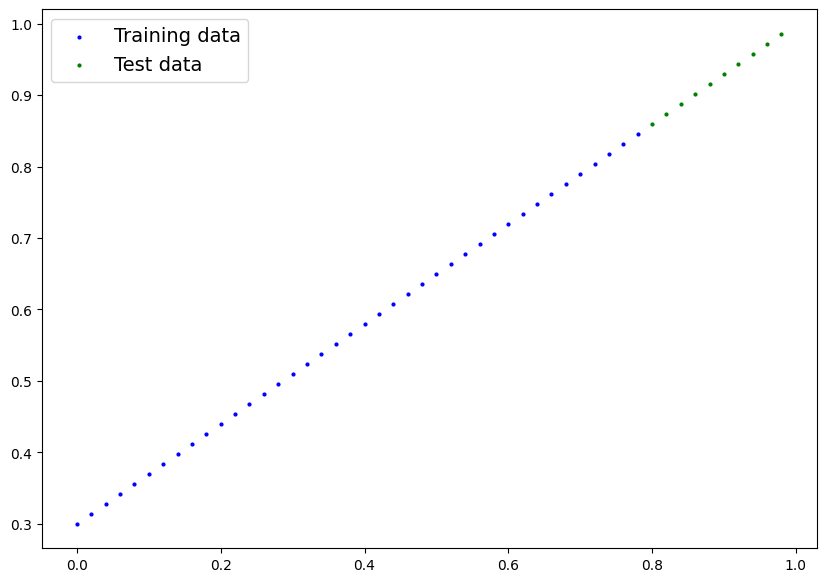

In [7]:
plot_predictions()

## 2. Build Model

What our model does:
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight & bias values we used to create the data)

How does it do so?

Through two main algorithms:
1. Gradient descent - https://youtu.be/IHZwWFHWa-w_
2. Backpropagation - https://youtu.be/Ilg3gGewQ5U

In [8]:
from torch import nn

# Create linear regression model class
class LinearRegressionModel(nn.Module): # <- almost every thing in PyTorch inherits from nn.Module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, # start with a random weight and try to adjust it to the ideal weight
                                            requires_grad=True, # <- can this parameter be updated via gradient descent?
                                            dtype=torch.float)) # <- PyTorch loves the datatype torch. float32


    self.bias = nn.Parameter(torch.randn(1,  # start with a random weight and try to adjust it to the ideal weight
                                         requires_grad=True, # <- can this parameter be updated via gradient descent?
                                         dtype=torch.float)) # <- PyTorch loves the datatype torch. float32


  # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
    return self.weights * x + self.bias # linear regression

### PyTorch model building essentials

* torch.nn - contains all of the building blocks for computational graphs (a neural network can be considered a computational graph)
* torch.nn.Paramter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - The base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim - this is where the optimizers in the PyTorch live. This will help with the gradient descent.
* def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computations

See more of these essential modules via the PyTorch cheatsheet - https://pytorch.org/tutorials/beginner/ptcheat.html

In [9]:
torch.manual_seed(42)
torch.randn(1)

tensor([0.3367])

### Checking the contents of our PyTorch model

Now we've created a model, let's see what's inside

In [10]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the odel (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [11]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

To check out model's predictive power, let's see how well it predicts `y_test` based on `X_test`

When we pass data through our model, it's going to run through the `forward()` method

In [12]:
# Make preditions with model
with torch.inference_mode():
  y_preds = model_0(X_test)

# # You can also do something similar with torch.no_grad(), however, inference_mode() is preferred.
# with torch.no_grad():
#   y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

See more on - https://x.com/PyTorch/status/1437838231505096708?lang=en

In [13]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

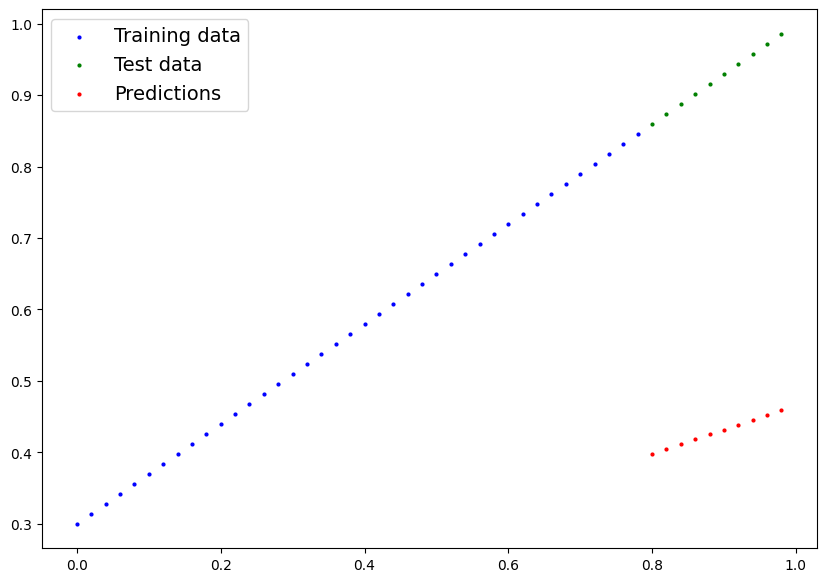

In [14]:
plot_predictions(predictions=y_preds)

## 3. Train Model

The whole idea of training is for a model to move from some *unknown* parameters (these maybe random) to some *known* parameters.

Or in another words from a poor representation of data to a good representation of data

One way to measure how poor or how wrong your model's prediction are you need to use a loss function

* Note: Loss function my also be called cost function or criterion in different areas. For our case, we're going to refer to it as a loss function.

Things we need to train:

* **Loss function:** A function to measure how wrong your model's prediction are to the ideal outputs, lower is better

* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters (e.g. weight & bias in our case) to improve the loss function - https://docs.pytorch.org/docs/stable/optim.html

  * Inside th optimizer you'll often have to set two parameters:
    * `params`- the model parameters you'd like to optimize, for example `params=model_0.parameters()`
    * `lr` (learning rate) - the learning rate is a hyperparameter that defines how big/small the optimizer changes the parameters with each step (a small `lr` results in small changes, a large `lr` results in large changes)

And specifically for PyTorch, we need:
* A training loop
* A testing loop

In [15]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [16]:
# Check out our model's parameters (a parameter is a value that the model sets itself)
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [17]:
# Setup a loss function
loss_fn = nn.L1Loss()
# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) # lr = learning rate = possibly the most important hyperparameter you can set

**Q:** Which loss function and optimizer should I use?

**A:** This will be problem specific. But with experience, you'll get an idea of what workd and what doesn't with your particular problem set.

For example, for a regression problem (like ours), a loss of `nn.L1Loss()` and an optimizer like `torch.optim.SGD()` will suffice.

But for a classification problem like classifying whether a photo is of a dog or a cat, you'll likely want to use a loss function of `nn.BCELOSS()` (binary cross entropy loss).

### Building a training loop (and a testing loop) in PyTorch

A couple of things we need in a training loop:
0. Loop through the data
1. Forward pass (this involves data moving through our model's `forward()` functions) to make predictions on data - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwords through the neural network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve our loss.(**gradient descent**)

In [24]:
with torch.no_grad():
  list(model_0.parameters())

In [22]:
list(model_0.eval().parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [25]:
# An epoch is one loop through the data... (this is a hyperparameter because we've set it ourselves)
epochs = 1

# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients


  model_0.eval() # turns off the gradient tracking